I want to make versions of my current functions which operate on all the activations of a dataset, not just the final activations

# Setup

In [1]:
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/AI-ML-Stuff/Dissertation/work/Transformer-Masking
  %pip install transformer_lens
  %pip install scikit-learn
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

Running as a Colab notebook
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/AI-ML-Stuff/Dissertation/work/Transformer-Masking


In [2]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook_connected" # or use "browser" if you want plots to open with browser
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from fancy_einsum import einsum
from typing import List, Optional, Callable, Tuple, Union, Dict
import functools
from tqdm import tqdm
from IPython.display import display
import random
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import json


from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

In [ ]:
gpt2_small = HookedTransformer.from_pretrained("gpt2-small").cuda()
gpt2_small.name = "gpt2 small"

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


In [3]:
gpt2_xl = HookedTransformer.from_pretrained("gpt2-xl").cuda()
gpt2_xl.name = "gpt2 xl"

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


# Datasets

In [ ]:
import json
family_datasets = {}

# Specify the file path
file_path = 'family_dataset1_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset1 = json.load(file)

  family_datasets["same name"] = dataset1


# Specify the file path
file_path = 'family_dataset2_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset2 = json.load(file)
  family_datasets["same relation"] = dataset2


# Specify the file path
file_path = 'family_dataset3_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset3 = json.load(file)

  family_datasets["same name and relation"] = dataset3

## Dataset Creation

In [ ]:
# Generate a dataset with all numbers from 0 to 1000

addition_dataset = [str(x) + " + " + str(y) + " =" for x in range(24) for y in range(24)]
odd_addition_dataset = [str(2 * x + 1) + " + " + str(2 * y + 1) + " =" for x in range(24) for y in range(24)]
even_addition_dataset = [str(2 * x) + " + " + str(2 * y) + " =" for x in range(24) for y in range(24)]
multiplication_dataset = [str(x) + " * " + str(y) + " =" for x in range(24) for y in range(24)]
even_multiplication_dataset = [str(2 * x ) + " * " + str(2 * y ) + " =" for x in range(24) for y in range(24)]
odd_multiplication_dataset = [str(2 * x + 1) + " * " + str(2 * y + 1) + " =" for x in range(24) for y in range(24)]
multiplication_dataset2 = [str(x) + " x " + str(y) + " =" for x in range(24) for y in range(24)]

In [ ]:
addition_dataset

['0 + 0 =',
 '0 + 1 =',
 '0 + 2 =',
 '0 + 3 =',
 '0 + 4 =',
 '0 + 5 =',
 '0 + 6 =',
 '0 + 7 =',
 '0 + 8 =',
 '0 + 9 =',
 '0 + 10 =',
 '0 + 11 =',
 '0 + 12 =',
 '0 + 13 =',
 '0 + 14 =',
 '0 + 15 =',
 '0 + 16 =',
 '0 + 17 =',
 '0 + 18 =',
 '0 + 19 =',
 '0 + 20 =',
 '0 + 21 =',
 '0 + 22 =',
 '0 + 23 =',
 '1 + 0 =',
 '1 + 1 =',
 '1 + 2 =',
 '1 + 3 =',
 '1 + 4 =',
 '1 + 5 =',
 '1 + 6 =',
 '1 + 7 =',
 '1 + 8 =',
 '1 + 9 =',
 '1 + 10 =',
 '1 + 11 =',
 '1 + 12 =',
 '1 + 13 =',
 '1 + 14 =',
 '1 + 15 =',
 '1 + 16 =',
 '1 + 17 =',
 '1 + 18 =',
 '1 + 19 =',
 '1 + 20 =',
 '1 + 21 =',
 '1 + 22 =',
 '1 + 23 =',
 '2 + 0 =',
 '2 + 1 =',
 '2 + 2 =',
 '2 + 3 =',
 '2 + 4 =',
 '2 + 5 =',
 '2 + 6 =',
 '2 + 7 =',
 '2 + 8 =',
 '2 + 9 =',
 '2 + 10 =',
 '2 + 11 =',
 '2 + 12 =',
 '2 + 13 =',
 '2 + 14 =',
 '2 + 15 =',
 '2 + 16 =',
 '2 + 17 =',
 '2 + 18 =',
 '2 + 19 =',
 '2 + 20 =',
 '2 + 21 =',
 '2 + 22 =',
 '2 + 23 =',
 '3 + 0 =',
 '3 + 1 =',
 '3 + 2 =',
 '3 + 3 =',
 '3 + 4 =',
 '3 + 5 =',
 '3 + 6 =',
 '3 + 7 ='

In [ ]:
random.shuffle(addition_dataset)
random.shuffle(multiplication_dataset)
combined_add_mult_dataset = addition_dataset + multiplication_dataset
random.shuffle(combined_add_mult_dataset)

In [ ]:
combined_add_mult_dataset = combined_add_mult_dataset[:24**2]

In [ ]:
def generate_random_addition_dataset(sqrt_n):
  # Generate some random tokens
  n = sqrt_n ** 2

  # Randomly sample 25 tokens
  random_token_choice = random.sample(list(range(50256)), sqrt_n)

  # Get the token for " +" (this is token 1343)
  add_token = 1343
  equal_token = 796
  EOS_token = 50256

  # Create the addition dataset using these random tokens
  random_token_addition_list = [t.Tensor([[EOS_token, a, add_token, b, equal_token]]) for a in random_token_choice for b in random_token_choice]

  dataset_tensor = t.cat(random_token_addition_list, dim=0)

  dataset_tensor = dataset_tensor.int()

  return dataset_tensor

In [ ]:
random_token_addition_dataset = generate_random_addition_dataset(24)

In [ ]:
random_token_addition_dataset.dtype

torch.int32

In [ ]:
# Shuffle the addition and multiplication datasets
def shuffle_string(s):
    # Split the string based on whitespace
    chars = s.split()

    # Shuffle the characters
    random.shuffle(chars)

    # Reintroduce whitespace between each character
    shuffled = ' '.join(chars)

    return shuffled

shuffled_addition_dataset = [shuffle_string(s) for s in addition_dataset]

In [ ]:
# Think the above leads to some tokenisation issues: just choose the tokens directly
shuffled_addition_dataset

['17 10 = +',
 '2 = 21 +',
 '14 + 13 =',
 '22 + = 10',
 '0 = 14 +',
 '+ 21 1 =',
 '= 16 + 2',
 '1 + 12 =',
 '+ 14 = 19',
 '+ = 12 19',
 '= + 0 4',
 '0 22 = +',
 '+ = 21 23',
 '9 + = 5',
 '= 5 + 1',
 '= 4 + 8',
 '20 23 + =',
 '+ 8 = 3',
 '+ 11 = 18',
 '= 16 + 19',
 '19 + = 7',
 '+ 3 = 13',
 '= 21 + 3',
 '+ 12 5 =',
 '12 11 = +',
 '9 + 18 =',
 '15 7 = +',
 '9 = 13 +',
 '0 4 + =',
 '+ 23 23 =',
 '23 = 12 +',
 '2 7 + =',
 '16 20 + =',
 '3 = 19 +',
 '8 = + 15',
 '4 15 + =',
 '= 6 + 21',
 '= 1 18 +',
 '= 12 + 20',
 '+ = 12 0',
 '12 + 9 =',
 '+ 2 = 7',
 '5 2 = +',
 '20 4 + =',
 '20 = + 0',
 '= + 9 3',
 '2 + = 1',
 '= 1 12 +',
 '12 21 = +',
 '= 19 + 1',
 '13 18 = +',
 '5 + 8 =',
 '7 14 = +',
 '+ 13 16 =',
 '+ 16 = 16',
 '4 4 + =',
 '12 + 18 =',
 '+ 8 10 =',
 '= 19 + 1',
 '+ 3 0 =',
 '= 6 12 +',
 '18 22 = +',
 '4 = + 9',
 '= 16 + 11',
 '3 + = 6',
 '+ 9 = 17',
 '12 13 = +',
 '21 + = 0',
 '10 = 0 +',
 '= 14 12 +',
 '= 11 13 +',
 '16 + = 21',
 '0 5 + =',
 '+ 18 18 =',
 '= 11 11 +',
 '22 11 = +',
 

In [ ]:
# Generate some random tokens
n = 24 ** 2

random_tokens = t.randint(low=1, high=50256, size=(n, 5))

# replace the first column with 50256
random_tokens[:, 0] = 50256

Todo: look at sampling from the tokeniser

Note that Gpt 3.5 has a larger tokeniser

In [ ]:
random_tokens.shape

torch.Size([576, 5])

In [ ]:
# Create the baseline dataset

def read_all_text_files(directory):
    # List to hold the contents of all files
    contents_list = []

    # List all files in directory
    for filename in os.listdir(directory):
        # Check if file is a text file
        if filename.endswith('.txt'):
            # Construct full file path
            filepath = os.path.join(directory, filename)

            # Open the file and read the contents
            with open(filepath, 'r') as f:
                contents = f.read()

            # Add the file contents to the list
            contents_list.append(contents)

    return contents_list

training_subset = {}
training_subset['urlsf_subset01-1_data'] = read_all_text_files('urlsf_subset01-1_data')
training_subset['urlsf_subset01-182_data'] = read_all_text_files('urlsf_subset01-182_data')

In [ ]:
training_subset_tokens = {}
token_list = [gpt2_small.to_tokens(s)[:,:5] for s in training_subset['urlsf_subset01-1_data']]
token_list += [gpt2_small.to_tokens(s)[:,:5] for s in training_subset['urlsf_subset01-182_data']]
training_subset_tokens = t.cat(token_list, dim=0)

### Repetition Datasets

In [ ]:
repetition_dataset_a = [f"Repeat the string '{chr(ord('a') + x)} {chr(ord('a') + y)} a'. {chr(ord('a') + x)} {chr(ord('a') + y)}" for x in range(26) for y in range(26)]

In [ ]:
repetition_dataset_f = [f"Repeat the string '{chr(ord('a') + x)} {chr(ord('a') + y)} f'. {chr(ord('a') + x)} {chr(ord('a') + y)}" for x in range(26) for y in range(26)]
repetition_dataset_u = [f"Repeat the string '{chr(ord('a') + x)} {chr(ord('a') + y)} u'. {chr(ord('a') + x)} {chr(ord('a') + y)}" for x in range(26) for y in range(26)]
repetition_dataset_q = [f"Repeat the string '{chr(ord('a') + x)} {chr(ord('a') + y)} q'. {chr(ord('a') + x)} {chr(ord('a') + y)}" for x in range(26) for y in range(26)]
repetition_dataset_w = [f"Repeat the string '{chr(ord('a') + x)} {chr(ord('a') + y)} w'. {chr(ord('a') + x)} {chr(ord('a') + y)}" for x in range(26) for y in range(26)]

In [ ]:
repetition_datasets = {
    "repeat a": repetition_dataset_a,
    "repeat f": repetition_dataset_f,
    "repeat u": repetition_dataset_u,
    "repeat q": repetition_dataset_q,
    "repeat w": repetition_dataset_w
}

In [ ]:
s = training_subset['urlsf_subset01-1_data'][0]
gpt2_large.to_tokens(s)[:,:5].shape

NameError: ignored

In [ ]:
training_subset_tokens.shape

In [ ]:
training_subset_tokens = training_subset_tokens[:n**2, :]

In [ ]:
[len(training_subset[key]) for key in training_subset]

In [ ]:
xs = [lst for lst in training_subset]

In [ ]:
xs

### Causal Family Datasets

In [ ]:
import json


In [ ]:
family_datasets = {}

In [ ]:
# Specify the file path
file_path = 'family_dataset1_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset1 = json.load(file)

  family_datasets["same name"] = dataset1

In [ ]:
# Specify the file path
file_path = 'family_dataset2_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset2 = json.load(file)
  family_datasets["same relation"] = dataset2

In [ ]:
# Specify the file path
file_path = 'family_dataset3_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset3 = json.load(file)

  family_datasets["same name and relation"] = dataset3

In [ ]:
# Specify the file path
file_path = 'family_dataset4_big.json'


# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset4 = json.load(file)

  family_datasets["same matriarch"] = dataset4

In [ ]:
datasets_lang2 = {
    "odd addition": odd_addition_dataset,
    "even addition": even_addition_dataset,
    "even multiplication": even_multiplication_dataset,
    "odd multiplication": odd_multiplication_dataset,
    "shuffled addition": shuffled_addition_dataset,
    "combined addition multiplication": combined_add_mult_dataset
}

In [ ]:
del family_datasets["same matriarch"]

### Adapted Family Datasets


In [ ]:
family_datasets_adap = {}

# Specify the file path
file_path = 'family_dataset1_adapted.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset1_adap = json.load(file)

  family_datasets_adap["same name"] = dataset1_adap

# Specify the file path
file_path = 'family_dataset2_adapted.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset2_adap = json.load(file)
  family_datasets_adap["same relation"] = dataset2_adap

# Specify the file path
file_path = 'family_dataset3_adapted.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset3_adap = json.load(file)

  family_datasets_adap["same name and relation"] = dataset3_adap

# Specify the file path
file_path = 'family_dataset4_adapted.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset4_adap = json.load(file)

  family_datasets_adap["same matriarch"] = dataset4_adap

In [ ]:
family_datasets_adap.keys()

###Story Datasets

In [4]:
stories_new = {}

In [5]:
# Specify the file path
file_path = 'story_questions/fantasy_genre_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_genre = json.load(file)

  stories_new["fantasy genre question"] = dataset_fantasy_genre

In [6]:
# Specify the file path
file_path = 'story_questions/fantasy_character_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_character = json.load(file)

  stories_new["fantasy character question"] = dataset_fantasy_character

In [7]:
# Specify the file path
file_path = 'story_questions/fantasy_likelihood_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_likelihood = json.load(file)

  stories_new["fantasy likelihood question"] = dataset_fantasy_likelihood

In [ ]:
# Specify the file path
file_path = 'story_questions/scifi_genre_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_scifi_genre = json.load(file)

  stories_new["scifi genre question"] = dataset_scifi_genre

In [ ]:
# Specify the file path
file_path = 'story_questions/sports_genre_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_sports_genre = json.load(file)

  stories_new["sports genre question"] = dataset_sports_genre

In [ ]:
# Specify the file path
file_path = 'story_questions/sports_likelihood_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_sports_likelihood = json.load(file)

  stories_new["sports likelihood question"] = dataset_sports_likelihood

In [ ]:
# Specify the file path
file_path = 'story_questions/sports_continuation_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_sports_continuation = json.load(file)

  stories_new["sports continuation question"] = dataset_sports_continuation

In [ ]:
# Specify the file path
file_path = 'story_questions/scifi_continuation_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_scifi_continuation = json.load(file)

  stories_new["scifi continuation question"] = dataset_scifi_continuation

In [ ]:
# Specify the file path
file_path = 'story_questions/fantasy_continuation_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_continuation = json.load(file)

  stories_new["fantasy continuation question"] = dataset_fantasy_continuation

In [9]:
# Specify the file path
file_path = 'sports_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_sports= json.load(file)

  stories_new["sports no question"] = dataset_sports

In [8]:
# Specify the file path
file_path = 'fantasy_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy = json.load(file)
  stories_new["fantasy no question"] = dataset_fantasy

In [10]:
# Specify the file path
file_path = 'scifi_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_scifi = json.load(file)
  stories_new["scifi no question"] = dataset_scifi

In [ ]:
fantasy_and_continuations = {
  "fantasy no question": dataset_fantasy,
  "fantasy continuation question" : dataset_fantasy_continuation,
  "scifi continuation question" : dataset_scifi_continuation,
  "sports continuation question" : dataset_sports_continuation,
  "fantasy genre question": dataset_fantasy_genre,
}

In [ ]:
dataset_sports

In [ ]:
# Specify the file path
file_path = 'story_questions/fantasy_genre2_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_genre2 = json.load(file)

  stories_new["fantasy genre2 question"] = dataset_fantasy_genre2

In [ ]:
# Specify the file path
file_path = 'story_questions/fantasy_genre3_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_genre3 = json.load(file)

  stories_new["fantasy genre3 question"] = dataset_fantasy_genre3

In [ ]:
# Specify the file path
file_path = 'story_questions/fantasy_genre4_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_genre4 = json.load(file)

  stories_new["fantasy genre4 question"] = dataset_fantasy_genre4

In [ ]:
# Specify the file path
file_path = 'story_questions/fantasy_genre5_200.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_fantasy_genre5 = json.load(file)

  stories_new["fantasy genre5 question"] = dataset_fantasy_genre5

In [ ]:
fantasy_datasets = {
  "fantasy no question": dataset_fantasy,
  "fantasy continuation question" : dataset_fantasy_continuation,
  "fantasy likelihood question": dataset_fantasy_likelihood,
  "fantasy genre question": dataset_fantasy_genre,
  "fantasy genre question 2": dataset_fantasy_genre2,
  "fantasy genre question 3": dataset_fantasy_genre3,
  "fantasy genre question 5": dataset_fantasy_genre5,
}

In [ ]:
stories_new2 = stories_new
del stories_new2["fantasy genre2 question"]
del stories_new2["fantasy genre3 question"]
del stories_new2["fantasy genre4 question"]
del stories_new2["fantasy genre5 question"]

In [ ]:
del stories_new2["fantasy no question"]
del stories_new2["scifi no question"]
del stories_new2["sports no question"]


# Functions

In [11]:
def SVD(matrix: t.Tensor) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
  """
  Compute the SVD of a matrix.
  Returns the three associated matrices
  """
  U, S, V_H = t.linalg.svd(matrix)
  return U, S, V_H


In [12]:
# Run a dataset through the model, store all the activations
def dataset_activations(
  model: HookedTransformer,
  dataset: List[str]
):
  # TODO: make this run in batches instead of at once.
  #
  # Tokenise the batch, form a batch tensor
  batch_tokens = model.to_tokens(dataset)
  # Feed the tensor through the model
  logits, cache = model.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)

  return logits, cache

In [13]:
from torch.nn.utils.rnn import pad_sequence

def dataset_activations_optimised_new(
  model: HookedTransformer,
  dataset: List[str],
  location: str,
  max_batch_size: int,
  use_all_activations: bool = False
):
  """
  Note: this function has been updated to also return all activations, if we want it to do this

  """
  num_batches = (len(dataset) + max_batch_size - 1) // max_batch_size
  all_activations = []

  # Process each batch
  for batch_idx in range(num_batches):
    t.cuda.empty_cache()
    # print("batch_idx be: ", batch_idx)
    # Determine the start and end index for this batch
    start_idx = batch_idx * max_batch_size
    end_idx = min(start_idx + max_batch_size, len(dataset))

    # Extract the subset of the dataset for this batch
    batch_subset = dataset[start_idx:end_idx]

    # Tokenise the batch, form a batch tensor
    batch_tokens = model.to_tokens(batch_subset)

    mask = batch_tokens != 50256
    final_indices = ((mask.cumsum(dim=1) == mask.sum(dim=1).unsqueeze(1)).int()).argmax(dim=1)
    final_indices = final_indices.view(-1,1)

    # print(batch_tokens)
    # Feed the tensor through the model
    _, cache = model.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)
    activations = cache[location]



    if use_all_activations:
      print("final indices be", final_indices)
      output_activations = select_vectors_parallel(final_indices.squeeze(), activations).cpu()
      print("output activations shape be", output_activations.shape)
    else:
      index_expanded = final_indices.unsqueeze(-1).expand(-1, -1, activations.size(2))
      # print("index_expanded: ", index_expanded)
      final_activations = t.gather(activations, 1, index_expanded)
      # Move the activations to the CPU and store them
      final_activations = final_activations.cpu()
      output_activations = final_activations.squeeze()

    all_activations.append(output_activations)

  all_activations = t.cat(all_activations, dim=0)

  print("all activations shape is: ", all_activations.shape)


  return all_activations

In [14]:
def select_vectors_parallel(indices, Y):
    """
    For each index, select every vector in Y up to and including the index.

    Parameters
    ----------
    indices : torch.Tensor
        Tensor of indices.
    Y : torch.Tensor
        Tensor of shape (batch, length, dimension).

    Returns
    -------
    torch.Tensor
        Stacked vectors.
    """
    assert len(indices.shape) == 1, "Indices tensor should be 1D"
    assert len(Y.shape) == 3, "Y tensor should be 3D"
    assert indices.shape[0] == Y.shape[0], "Batch size should match"

    # Create a mask of shape (batch, length)
    mask = t.arange(Y.shape[1]).expand(indices.shape[0], Y.shape[1]).to(Y.device) <= indices.unsqueeze(1)

    # Expand mask to match the shape of Y
    mask = mask.unsqueeze(2).expand_as(Y)

    # Apply mask and remove extra dimensions
    selected_vectors = Y[mask].view(-1, Y.shape[-1])

    return selected_vectors

# Example usage:
batch = 2
length = 15
dimension = 400

indices = t.tensor([5, 7]).cuda()  # On GPU
Y = t.rand((batch, length, dimension)).cuda()  # On GPU

selected_vectors = select_vectors_parallel(indices, Y)

print(selected_vectors)


tensor([[1.3883e-01, 1.0066e-01, 7.1846e-01,  ..., 3.6156e-01, 9.9441e-01,
         6.4415e-04],
        [6.5889e-02, 4.1863e-01, 8.3910e-01,  ..., 5.5156e-01, 2.7612e-01,
         9.0604e-01],
        [6.2925e-01, 1.7083e-01, 6.1621e-01,  ..., 3.7336e-01, 1.8943e-01,
         1.1986e-01],
        ...,
        [2.5021e-01, 5.6020e-02, 3.9277e-01,  ..., 8.0602e-01, 9.3360e-01,
         5.6707e-01],
        [1.3123e-01, 1.9018e-01, 1.8772e-01,  ..., 6.2304e-01, 6.0404e-01,
         7.0501e-01],
        [6.9288e-01, 5.9097e-01, 5.1794e-02,  ..., 4.0059e-01, 2.0181e-01,
         6.4615e-01]], device='cuda:0')


In [15]:
def dataset_activations_optimised_locations(
  model: HookedTransformer,
  dataset: List[str],
  layers: int,
  location: str,
  max_batch_size: int
):
  """
  Same as earlier function, but returns activations for all locations.
  """

  num_batches = (len(dataset) + max_batch_size - 1) // max_batch_size
  all_final_activations = {}

  # Process each batch
  for batch_idx in range(num_batches):
    t.cuda.empty_cache()
    # print("batch_idx be: ", batch_idx)
    # Determine the start and end index for this batch
    start_idx = batch_idx * max_batch_size
    end_idx = min(start_idx + max_batch_size, len(dataset))

    # Extract the subset of the dataset for this batch
    batch_subset = dataset[start_idx:end_idx]

    # Tokenise the batch, form a batch tensor
    batch_tokens = model.to_tokens(batch_subset)

    mask = batch_tokens != 50256
    final_indices = ((mask.cumsum(dim=1) == mask.sum(dim=1).unsqueeze(1)).int()).argmax(dim=1)
    final_indices = final_indices.view(-1,1)

    # print(batch_tokens)
    # Feed the tensor through the model
    _, cache = model.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)

    for layer in range(layers):
      activations = cache[location.format(layer)]
      # # Take the last activation
      index_expanded = final_indices.unsqueeze(-1).expand(-1, -1, activations.size(2))
      # print("index_expanded: ", index_expanded)
      final_activations = t.gather(activations, 1, index_expanded)
      # Move the activations to the CPU and store them
      final_activations = final_activations.cpu()
      final_activations = final_activations.squeeze()
      all_final_activations.setdefault(layer, []).append(final_activations)



  for layer in range(layers):
    all_final_activations[layer] = t.cat(all_final_activations[layer], dim=0)


  return all_final_activations

In [16]:
def dataset_activations_optimised_locations_new(
  model: HookedTransformer,
  dataset: List[str],
  layers: int,
  location: str,
  max_batch_size: int,
  use_all_activations: bool = False
):
  """
  Same as earlier function, but returns activations for all locations.
  Can also return activations from all positions, not just the final token.
  """

  num_batches = (len(dataset) + max_batch_size - 1) // max_batch_size
  all_activations = {}

  # Process each batch
  for batch_idx in range(num_batches):
    t.cuda.empty_cache()
    # print("batch_idx be: ", batch_idx)
    # Determine the start and end index for this batch
    start_idx = batch_idx * max_batch_size
    end_idx = min(start_idx + max_batch_size, len(dataset))

    # Extract the subset of the dataset for this batch
    batch_subset = dataset[start_idx:end_idx]

    # Tokenise the batch, form a batch tensor
    batch_tokens = model.to_tokens(batch_subset)

    mask = batch_tokens != 50256
    final_indices = ((mask.cumsum(dim=1) == mask.sum(dim=1).unsqueeze(1)).int()).argmax(dim=1)
    final_indices = final_indices.view(-1,1)

    # print(batch_tokens)
    # Feed the tensor through the model
    _, cache = model.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)

    for layer in range(layers):
      activations = cache[location.format(layer)]
      if use_all_activations:
        output_activations = select_vectors_parallel(final_indices.squeeze(), activations).cpu()
      else:
        index_expanded = final_indices.unsqueeze(-1).expand(-1, -1, activations.size(2))
        # print("index_expanded: ", index_expanded)
        final_activations = t.gather(activations, 1, index_expanded)
        # Move the activations to the CPU and store them
        final_activations = final_activations.cpu()
        output_activations = final_activations.squeeze()

      all_activations.setdefault(layer, []).append(output_activations)



  for layer in range(layers):
    all_activations[layer] = t.cat(all_activations[layer], dim=0)


  return all_activations

In [17]:
# Reshape into a matrix (looks at activations of each token)

def reshape_activations(
  batch_activations: t.Tensor
) -> t.Tensor:
  squeezed_tensor = einops.rearrange(batch_activations, 'b tokens dim -> (b tokens) dim')
  return squeezed_tensor



In [18]:
def activation_SVD(
    model: HookedTransformer,
    dataset: List[str],
    location: str
) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
  _, cache = dataset_activations(model, dataset)
  activation_cache = cache[location]
  squeezed_activations = reshape_activations(activation_cache)
  U, S, V_H = SVD(squeezed_activations)
  return U, S, V_H


In [19]:
# Run a dataset through the model, store all the activations
def dataset_activations_tokens(
  model: HookedTransformer,
  dataset_tokens: t.Tensor
):
  # Tokenise the batch, form a batch tensor
  batch_tokens = dataset_tokens
  # Feed the tensor through the model
  logits, cache = model.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)
  return logits, cache

def reshape_activations(
  batch_activations: t.Tensor
) -> t.Tensor:
  squeezed_tensor = einops.rearrange(batch_activations, 'b tokens dim -> (b tokens) dim')
  return squeezed_tensor

def activation_SVD_tokens(
    model: HookedTransformer,
    dataset_tokens: List[str],
    location: str
) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
  _, cache = dataset_activations_tokens(model, dataset_tokens)
  activation_cache = cache[location]
  squeezed_activations = reshape_activations(activation_cache)
  U, S, V_H = SVD(squeezed_activations)
  return U, S, V_H

In [20]:
def activation_SVD_covariance(
    model: HookedTransformer,
    dataset_tokens: List[str],
    location: str
) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
  """
  Similar to normal covariance, but we look at the normalised covariance matrix instead.
  """
  _, cache = dataset_activations_tokens(model, dataset_tokens)
  activation_cache = cache[location]
  squeezed_activations = reshape_activations(activation_cache)
  print(squeezed_activations.shape)
  mean_activation = squeezed_activations.mean(dim=0, keepdim=True)
  centred_activations = squeezed_activations - mean_activation
  covariance_matrix = centred_activations.T @ centred_activations
  print(covariance_matrix.shape)
  U, S, V_H = SVD(covariance_matrix)
  return U, S, V_H


# activation_SVD_covariance(gpt2_small, multiplication_dataset, 'blocks.5.hook_attn_out')



In [21]:
# Using tokens as a starting point, and also using the covariance matrix
def activation_SVD_tokens_covariance(
    model: HookedTransformer,
    dataset_tokens: List[str],
    location: str
) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
  _, cache = dataset_activations_tokens(model, dataset_tokens)
  activation_cache = cache[location]
  squeezed_activations = reshape_activations(activation_cache)
  mean_activation = squeezed_activations.mean(dim=0, keepdim=True)
  centred_activations = squeezed_activations - mean_activation
  covariance_matrix = centred_activations.T @ centred_activations
  U, S, V_H = SVD(covariance_matrix)
  return U, S, V_H

# Singular Vector Functions

In [22]:
def dataset_projection(
    X: t.Tensor,
    B: t.Tensor
) -> t.Tensor:
  """
  Take in dataset X (with datapoints as rows) and an orthogonal basis B of a subspace.

  The basis should be of dimension D x M, with M vectors in the basis each of dim D.

  Compute the projection of each datapoint on this subspace, store the results as
  another dataset in the same form as the original.
  """

  return B.T @ B @ X.T


In [23]:
def top_k_projection(
    X: t.Tensor,
    V_H: t.Tensor,
    k: int
) -> t.Tensor:
  """
  Project the dataset X onto the top k orthogonal basis vectors in V_H
  """
  B = V_H[:k,:]
  proj = dataset_projection(X, B)
  return proj.T

In [24]:
def matrix_error(
    X_1: t.Tensor,
    X_2: t.Tensor
) -> int:
  """
  Treat X_1 and X_2 as rows of datapoints.
  Then, take the difference between these matrices,
  compute the l_2 norm of each row,
  and then sum these norms.

  Return the sum of these norms.
  """
  X = X_1 - X_2
  norms = t.norm(X, dim=1, p=2)
  sum_of_norms = t.sum(norms)

  return sum_of_norms

# PCA Reconstruction Errors

In [25]:
def pca_reconstruction_errors_new(
    model: HookedTransformer,
    target_dataset: List[str],
    comparison_datasets: Dict[str, List[str]],
    k: int,
    layers: int,
    location: str,
    use_all_activations: bool = False
):
  """
  Given a target dataset and a comparison dataset, with a transformer model,
  for each location in the model:
    1. Compute the singular value decomposition of activations of the final token
    of the model for the target dataset.
    2. Consider the subspace corresponding to the top k principle components. (determine k lmao)
    3. Project the activations corresponding to the comparison dataset onto this subspace.
    4. Look at the L_2 error of the reconstruction (as a fraction of the total length).

  Repeat this for every location in the model, construct a plot for the MLP layers, the attention layers, and
  the residual stream.
  """
  # Get the number of layers of the model
  # Shouldn't hardcode, but I know this for gpt2 xl is 48
  all_accuracies = {}
  all_comparison_activations_dict = {}
  target_activations_dict = dataset_activations_optimised_locations_new(
    model,
    target_dataset,
    layers,
    location,
    2,
    use_all_activations
  )
  for name, comparison_dataset in comparison_datasets.items():
    comparison_activations_dict = dataset_activations_optimised_locations_new(
      model,
      comparison_dataset,
      layers,
      location,
      2,
      use_all_activations
    )

    all_comparison_activations_dict[name] = comparison_activations_dict

    all_accuracies[name] = []

  for layer in range(layers):
    target_activations = target_activations_dict[layer]
    # Do SVD
    print("Doing an SVD! Layer be: ", layer)
    _, _, V_H = SVD(target_activations)
    print("Done!")


    for name, comparison_dataset in comparison_datasets.items():
      comparison_activations_dict = all_comparison_activations_dict[name]
      comparison_activations = comparison_activations_dict[layer]
      # Project the comparison activations onto the top k vectors of V_H
      comparison_approx = top_k_projection(comparison_activations, V_H, k)

      # Get the errors
      error = matrix_error(comparison_approx, comparison_activations)
      total_l2_norms = t.sum(t.norm(comparison_activations, dim=1, p=2))
      error_fraction = error / total_l2_norms
      all_accuracies[name].append(1 - error_fraction)

  print(all_accuracies)

  for name, accuracies in all_accuracies.items():
    plt.plot(accuracies, label=name)
  plt.ylabel("Reconstruction accuracies (as fraction of original)")
  plt.xlabel("Layer")
  plt.title(f"Reconstruction accuracies of comparison projection on top {k} vectors of target activations at {location}")
  plt.legend()
  plt.show()




In [26]:
def pca_reconstruction_errors_self(
    model: HookedTransformer,
    datasets: Dict[str, List[str]],
    k: int,
    layers: int,
    location: str
):
  """
  Given a target dataset and a comparison dataset, with a transformer model,
  for each location in the model:
    1. Compute the singular value decomposition of activations of the final token
    of the model for the target dataset.
    2. Consider the subspace corresponding to the top k principle components. (determine k lmao)
    3. Project the activations corresponding to the comparison dataset onto this subspace.
    4. Look at the L_2 error of the reconstruction (as a fraction of the total length).

  Repeat this for every location in the model, construct a plot for the MLP layers, the attention layers, and
  the residual stream.
  """
  # Get the number of layers of the model
  # Shouldn't hardcode, but I know this for gpt2 xl is 48
  all_accuracies = {}
  all_activations_dict = {}

  for name, dataset in datasets.items():
    activations_dict = dataset_activations_optimised_locations(
      model,
      dataset,
      layers,
      location,
      2
    )

    all_activations_dict[name] = activations_dict

    all_accuracies[name] = []

    for layer in range(layers):
        # do SVD
        activations = all_activations_dict[name][layer]
        _, _, V_H = SVD(activations)

        # Project the comparison activations onto the top k vectors of V_H
        approx = top_k_projection(activations, V_H, k)

        # Get the errors
        error = matrix_error(approx, activations)
        total_l2_norms = t.sum(t.norm(activations, dim=1, p=2))
        error_fraction = error / total_l2_norms
        all_accuracies[name].append(1 - error_fraction)

        gc.collect()
        t.cuda.empty_cache()

  print(all_accuracies)

  for name, accuracies in all_accuracies.items():
    plt.plot(accuracies, label=name)
  plt.ylabel("Reconstruction accuracies (as fraction of original)")
  plt.xlabel("Layer")
  plt.title(f"Reconstruction accuracies of projection on top {k} vectors of activations at {location}")
  plt.legend()
  plt.show()

In [27]:
def activation_plot_final_acts_optimised_new(
  model: HookedTransformer,
  datasets_lang: List[str],
  datasets_tokens: List,
  plot_type: str,
  location: str,
  dimension: int,
  random: bool = False,
  centre: bool = True,
  use_all_activations: bool = False
):
  """
  Given a dataset, create a plot of the activations for the final token.
  Use gpt 2 small, look at any given location.
  Works for either numerical or categorical labels.
  Should support both t-SNE and PCA.

  Also has the ability to
  """
  t.cuda.empty_cache()
  activation_dict = {}
  # Do the forward pass for each dataset
  for name in datasets_lang:
    dataset_lang = datasets_lang[name]
    final_activations = dataset_activations_optimised_new(model, dataset_lang, location, 2, use_all_activations)
    # Looking at the final activations! Might want to change this?

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy
    print("data numpy shape is: ", data_numpy.shape)

  for name in datasets_tokens:
    dataset_token = datasets_tokens[name]
    activations = dataset_activations_tokens(model, dataset_token)[1][location]
    # Looking at the final activations! Might want to change this?
    final_activations = activations[:,-1,:]

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy

  all_data = []
  all_labels = []
  for label, data in activation_dict.items():
      all_data.append(data)
      all_labels.extend([label] * len(data))

  all_data = np.concatenate(all_data, axis=0)

  print("all data shape is: ", all_data.shape)

  if random:

    # Determine the number of data points per label (assuming all labels have the same number of data points)
    num_points_per_label = len(activation_dict[list(activation_dict.keys())[0]])

    # Calculate the mean and variance of the entire dataset
    mean = np.mean(all_data, axis=0)
    variance = np.var(all_data, axis=0)
    # Generate some random data
    # Will use the same mean and variance as the data
    # Generate synthetic data with the same variance
    if centre:
      synthetic_data = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    else:
      zeros = 0 * mean
      synthetic_data = np.random.normal(loc=zeros, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    synthetic_labels = ['Synthetic'] * len(synthetic_data)

    # Concatenate the synthetic data with the original data
    all_data = np.concatenate([all_data, synthetic_data], axis=0)
    all_labels.extend(synthetic_labels)



  # Initialize the t-SNE
  tsne = TSNE(n_components=2, random_state=21)

  # Fit and transform the data to 2D
  data_2d = tsne.fit_transform(all_data)

  data_2d_copy, all_labels_copy = data_2d, all_labels


  # Shuffle the data and labels
  data_2d, all_labels = shuffle(data_2d, all_labels, random_state=42)

  # Plot the transformed data
  # Create a colormap for labels
  unique_labels = list(set(all_labels))
  colors = plt.cm.get_cmap('viridis', len(unique_labels))

  # Plot the transformed data with labels
  plt.figure(figsize=(6, 5))
  markers = ['o', 's', '^', 'D', 'P']

  # Plot all points together, coloring them based on their labels
  for i, label in enumerate(all_labels):
      color_idx = unique_labels.index(label)
      marker = markers[color_idx % len(markers)]
      plt.scatter(data_2d[i, 0], data_2d[i, 1], color=colors(color_idx), s=20, alpha=0.6, label=label if color_idx not in [unique_labels.index(lbl) for lbl in all_labels[:i]] else "", marker=marker)

  # Add a legend
  handles, labels = plt.gca().get_legend_handles_labels()
  plt.legend(handles, labels, title="Labels")

  plt.xlabel('t-SNE feature 0')
  plt.ylabel('t-SNE feature 1')
  plt.title(f't-SNE visualization of the final activations of {model.name} at {location}')
  plt.show()
  return data_2d_copy, all_labels_copy

In [28]:
addition_dataset = [str(x) + " + " + str(y) + " =" for x in range(24) for y in range(24)]
multiplication_dataset = [str(x) + " * " + str(y) + " =" for x in range(24) for y in range(24)]

# Tests

In [ ]:
dataset_activations_optimised(
  gpt2_small,
  dataset = dataset_sports,
  location = "blocks.11.hook_resid_post",
  max_batch_size=2,
  use_all_activations = True
)

tensor([[[119, 119, 119,  ..., 119, 119, 119]],

        [[103, 103, 103,  ..., 103, 103, 103]]], device='cuda:0')
torch.Size([2, 120, 768])


UnboundLocalError: ignored

In [ ]:
activations = dataset_activations_optimised_new(
  gpt2_small,
  dataset = dataset_fantasy,
  location = "blocks.11.hook_resid_post",
  max_batch_size=16,
  use_all_activations = True
)

final indices be tensor([[132],
        [117],
        [137],
        [130],
        [133],
        [131],
        [139],
        [119],
        [137],
        [128],
        [108],
        [130],
        [122],
        [123],
        [141],
        [139]], device='cuda:0')
output activations shape be torch.Size([2082, 768])
final indices be tensor([[126],
        [126],
        [135],
        [120],
        [133],
        [144],
        [125],
        [119],
        [129],
        [135],
        [136],
        [117],
        [133],
        [138],
        [118],
        [113]], device='cuda:0')
output activations shape be torch.Size([2063, 768])
final indices be tensor([[121],
        [124],
        [129],
        [128],
        [148],
        [127],
        [139],
        [115],
        [ 98],
        [143],
        [128],
        [132],
        [131],
        [120],
        [106],
        [124]], device='cuda:0')
output activations shape be torch.Size([2029, 768])
final indices be te

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
{'sports no question': [tensor(0.6935), tensor(0.6986), tensor(0.7244), tensor(0.6911), tensor(0.6668), tensor(0.6474), tensor(0.6259), tensor(0.6085), tensor(0.5956), tensor(0.5918), tensor(0.6387), tensor(0.7515)], 'fantasy genre question': [tensor(0.7706), tensor(0.7773), tensor(0.7888), tensor(0.7595), tensor(0.7394), tensor(0.7247), tensor(0.7113), tensor(0.7015), tensor(0.6986), tensor(0.7072), tensor(0.7502), tensor(0.8390)]}


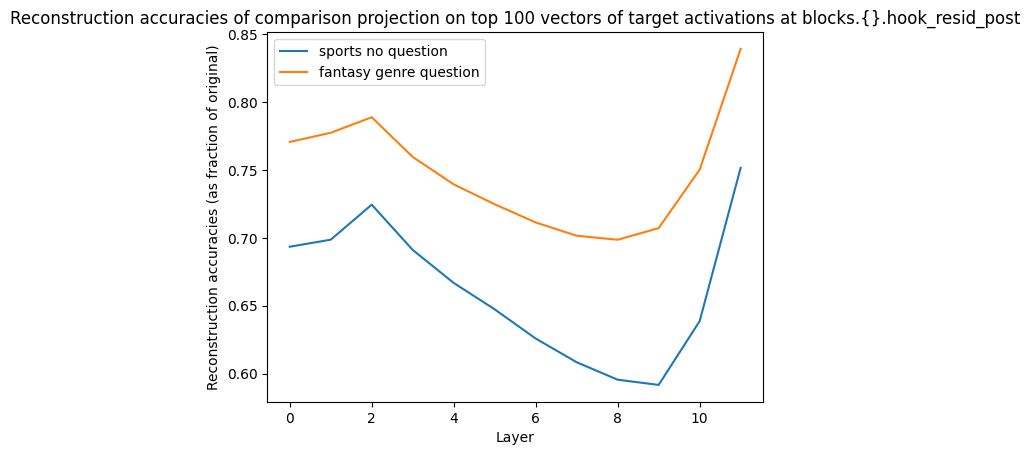

In [ ]:
pca_reconstruction_errors_new(
    gpt2_small,
    dataset_fantasy_genre,
    stories_new,
    100,
    12,
    "blocks.{}.hook_resid_post",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
{'sports no question': [tensor(0.4007), tensor(0.0951), tensor(0.3083), tensor(0.3137), tensor(0.3133), tensor(0.3063), tensor(0.2923), tensor(0.2708), tensor(0.2463), tensor(0.2197), tensor(0.2276), tensor(0.5966)], 'fantasy genre question': [tensor(0.3903), tensor(0.0860), tensor(0.2827), tensor(0.2881), tensor(0.2868), tensor(0.2819), tensor(0.2703), tensor(0.2502), tensor(0.2297), tensor(0.2082), tensor(0.2270), tensor(0.6193)], 'fantasy character question': [tensor(0.3860), tensor(0.0832), tensor(0.2741), tensor(0.2793), tensor(0.2788), tensor(0.2746), tensor(0.2632), tensor(0.2438), tensor

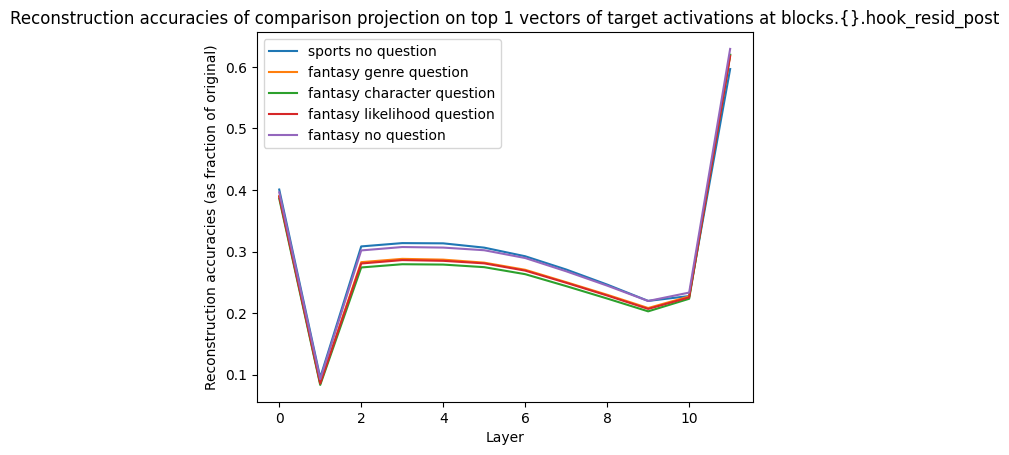

In [ ]:
pca_reconstruction_errors_new(
    gpt2_small,
    dataset_fantasy,
    stories_new,
    1,
    12,
    "blocks.{}.hook_resid_post",
    True
)

In [ ]:
import gc
gc.collect()
t.cuda.empty_cache()

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

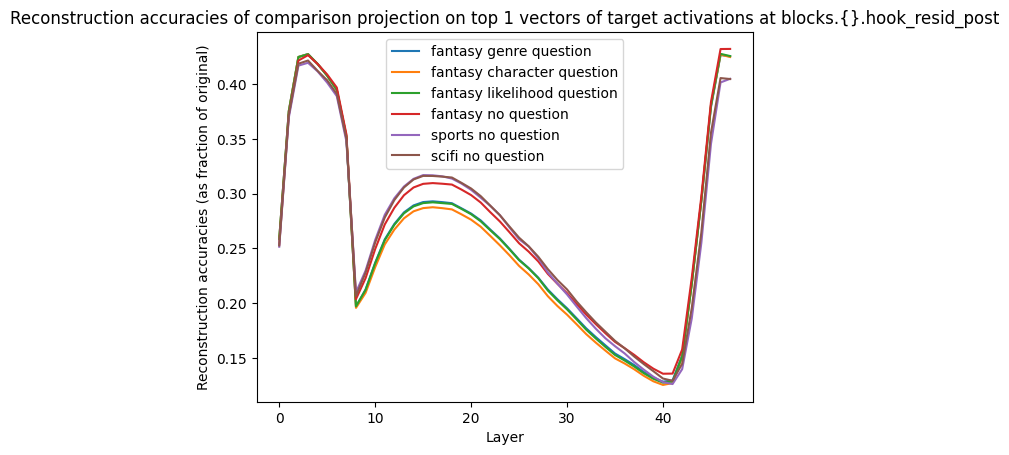

In [29]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    1,
    48,
    "blocks.{}.hook_resid_post",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

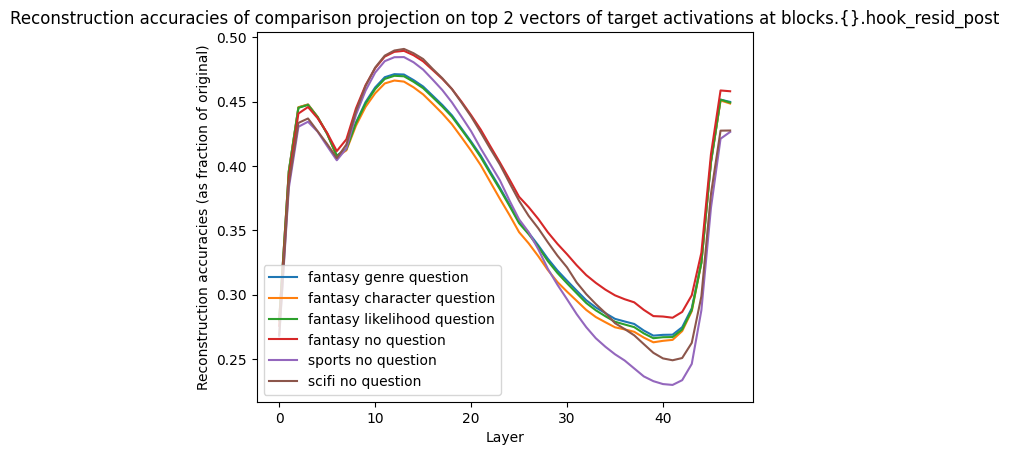

In [30]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    2,
    48,
    "blocks.{}.hook_resid_post",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

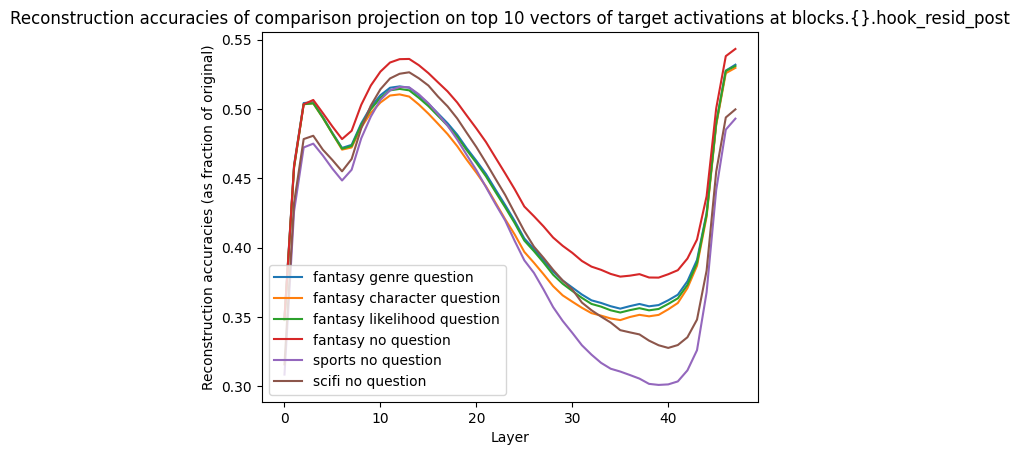

In [31]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    10,
    48,
    "blocks.{}.hook_resid_post",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

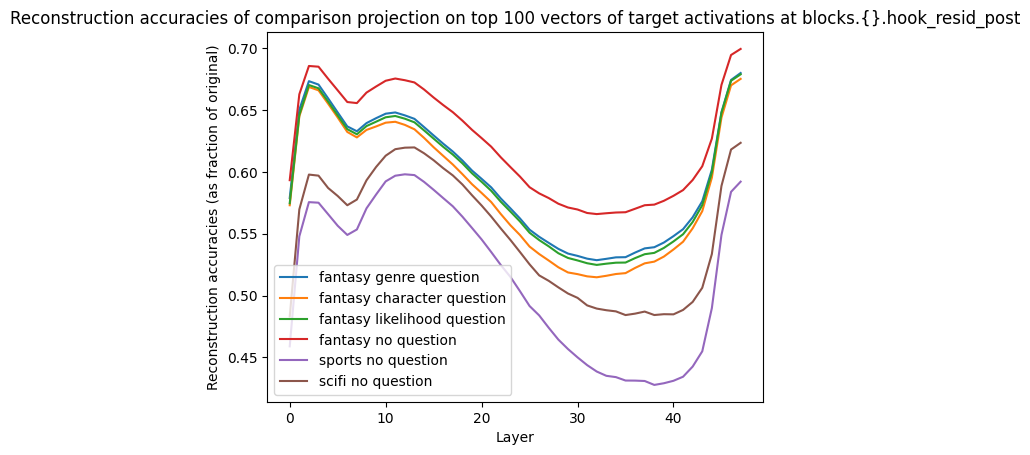

In [36]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    100,
    48,
    "blocks.{}.hook_resid_post",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

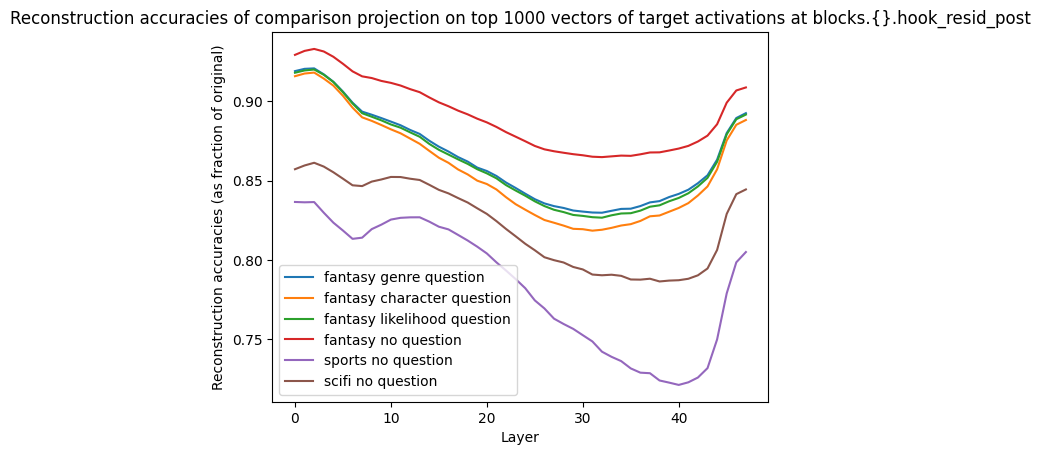

In [37]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    1000,
    48,
    "blocks.{}.hook_resid_post",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

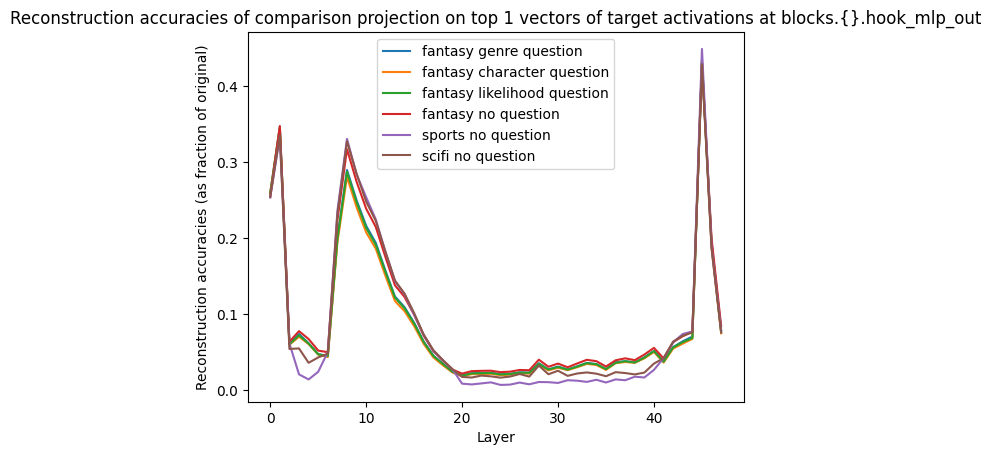

In [32]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    1,
    48,
    "blocks.{}.hook_mlp_out",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

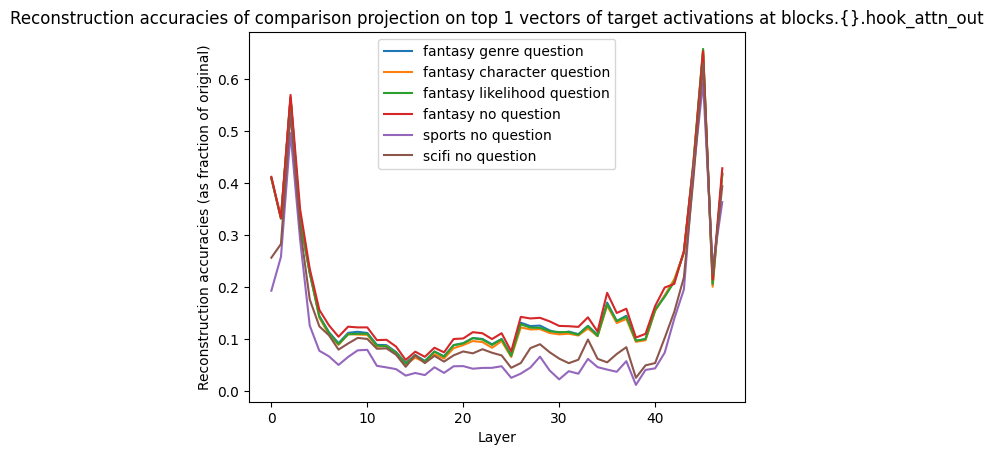

In [33]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    1,
    48,
    "blocks.{}.hook_attn_out",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

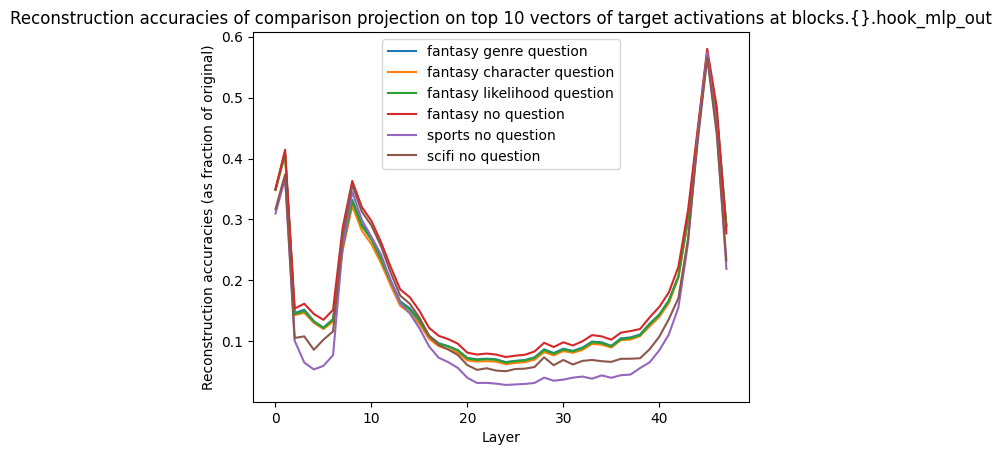

In [34]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    10,
    48,
    "blocks.{}.hook_mlp_out",
    True
)

Doing an SVD! Layer be:  0
Done!
Doing an SVD! Layer be:  1
Done!
Doing an SVD! Layer be:  2
Done!
Doing an SVD! Layer be:  3
Done!
Doing an SVD! Layer be:  4
Done!
Doing an SVD! Layer be:  5
Done!
Doing an SVD! Layer be:  6
Done!
Doing an SVD! Layer be:  7
Done!
Doing an SVD! Layer be:  8
Done!
Doing an SVD! Layer be:  9
Done!
Doing an SVD! Layer be:  10
Done!
Doing an SVD! Layer be:  11
Done!
Doing an SVD! Layer be:  12
Done!
Doing an SVD! Layer be:  13
Done!
Doing an SVD! Layer be:  14
Done!
Doing an SVD! Layer be:  15
Done!
Doing an SVD! Layer be:  16
Done!
Doing an SVD! Layer be:  17
Done!
Doing an SVD! Layer be:  18
Done!
Doing an SVD! Layer be:  19
Done!
Doing an SVD! Layer be:  20
Done!
Doing an SVD! Layer be:  21
Done!
Doing an SVD! Layer be:  22
Done!
Doing an SVD! Layer be:  23
Done!
Doing an SVD! Layer be:  24
Done!
Doing an SVD! Layer be:  25
Done!
Doing an SVD! Layer be:  26
Done!
Doing an SVD! Layer be:  27
Done!
Doing an SVD! Layer be:  28
Done!
Doing an SVD! Layer be: 

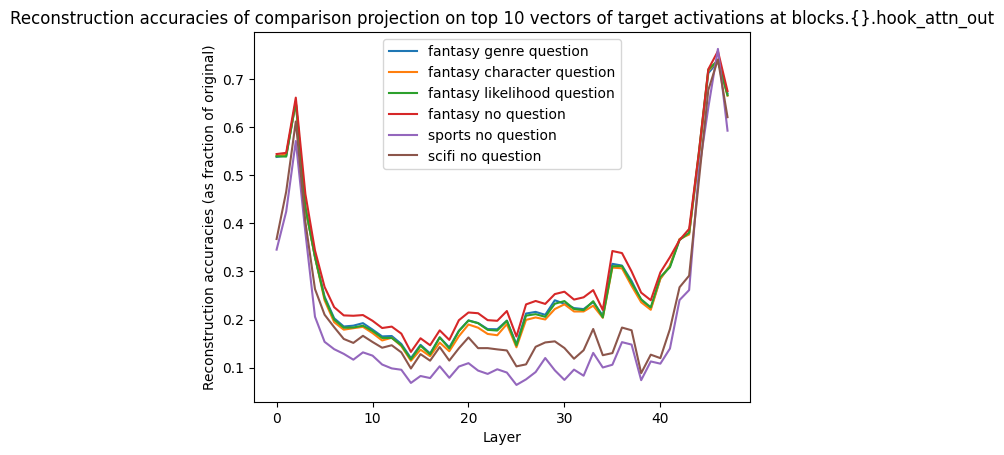

In [35]:
pca_reconstruction_errors_new(
    gpt2_xl,
    dataset_fantasy,
    stories_new,
    10,
    48,
    "blocks.{}.hook_attn_out",
    True
)

In [ ]:
stories_new.keys()

dict_keys(['sports no question', 'fantasy genre question', 'fantasy character question', 'fantasy likelihood question', 'fantasy no question'])

In [ ]:
dataset_fantasy

["In the land of Ethoria, a young sorcerer named Arden ventured into the forbidden forest in search of ancient relics. As he stepped into the dense foliage, whispers echoed through the trees, warning of an ancient curse. Ignoring the caution, Arden discovered a hidden cave filled with shimmering artifacts. He picked up a crystalline amulet, feeling its untamed power course through his veins. Little did he know, the amulet held a malevolent spirit longing to be free. As the moonlit night fell, Arden's eyes turned an ominous shade of emerald as he unleashed his newfound abilities, unknowingly becoming the very curse he sought to uncover.",
 'In a realm where dreams held sway, a young girl named Evangeline discovered her unique ability. With a touch, she could awaken the shadows of forgotten tales, and breathe life into mythical creatures. One moonlit night, she stumbled upon a neglected book, bound in gleaming silver. Fascinated, she traced her fingers across the cover, releasing a blind